In [1]:
import os
from PIL import Image, ImageOps, ImageEnhance, ImageFilter
import numpy as np
from tqdm import tqdm
import matplotlib
from matplotlib import pyplot as plt
import copy
import cv2
from sklearn.model_selection import train_test_split

import tensorflow as tf

In [2]:
print(os.listdir('../input/letteridentification/training/training'))

['background', 'hi']


In [3]:


def findImageLetter(path, additions0, additions1):
    
    data =r'../input/letteridentification/training/training'
    folder_name = 'hi'
    image_ne = []
    
    for filename in tqdm(os.listdir(data + '/' + folder_name),disable=True):
        
        image_name = path.split('_')
        image_name = image_name[0] + '_' + image_name[1]
        
        if additions0[0] in filename and image_name in filename and additions1[0] in filename:
            file_name = data + '/' + folder_name + '/' + filename
            image_n = copy.deepcopy(np.array(Image.open(file_name),dtype = np.uint8))
            image_n = np.asarray(image_n)
            image_ne.append(image_n)
            
    return image_ne


#print(findImageLetter('displayPanel_0',['flip'], ['sharpen']))


def findImageLetterB(path, additions0, additions1):
    
    data = r'../input/letteridentification/training/training'
    folder_name = 'background'
    image_ne = []
    
    for filename in tqdm(os.listdir(data + '/' + folder_name),disable=True):
        
        image_name = path.split('_')
        image_name = image_name[0] + '_' + image_name[1]
        
        if additions0[0] in filename and image_name in filename and additions1[0] in filename:
            file_name = data + '/' + folder_name + '/' + filename
            image_n = copy.deepcopy(np.array(Image.open(file_name),dtype=np.uint8))
            image_n = np.asarray(image_n)
            image_ne.append(image_n)
            
    return image_ne

def findImageNotLetter(path, additions0 = ['none','flip','rotate'] , additions1 = ['none.jpg','edgeEnhance.jpg','smooth.jpg','sharpen.jpg','blur.jpg']):
    
    image_ne = []
    data = r'../input/letteridentification/training/training'
    folder_name = 'background'

    for filename in tqdm(os.listdir(data + '/' + folder_name),disable=True):
        
        image_name = path.split('_')
        image_name = image_name[0] + '_' + image_name[1]

        back_image_name = filename.split('_')

        additions3 = back_image_name[2]
        additions4 = back_image_name[3]
        
        for add0 in additions0 :

            for add1 in additions1 :

                if add0 == additions3 and image_name in filename and add1 == additions4:
                    
                    image = copy.deepcopy(Image.open(data + '/' + folder_name + '/' + filename))

                    if add0 in ['flip'] :
                        image = ImageOps.mirror(image)

                    elif add0 in ['rotate'] :
                        image = image.rotate(180)
                    
                    image = np.asarray(image)

                    if(len(image.shape) == 4):
                        image = image[0,:,:,:]

                    image_ne.append(image)
                    return image_ne
        
    return image_ne

def subtractImages(image0, image1):
    image_1 = np.asarray(image0)
    image_2 = np.asarray(image1)

    black_pixels = np.where(
        (image_2[:, :, 0] < 4) &
        (image_2[:, :, 1] < 4) &
        (image_2[:, :, 2] < 4)
    )

    # set those pixels to white
    # image_2[black_pixels] = [255, 255, 255]

    image_final = cv2.absdiff(image_1, image_2)
    kernel = np.ones((2, 2), np.uint8)

    opening = cv2.morphologyEx(image_final, cv2.MORPH_OPEN, kernel)

    image_final = cv2.cvtColor(opening, cv2.COLOR_BGR2GRAY)
    ret, image_final = cv2.threshold(image_final, 17, 255, cv2.THRESH_BINARY)
    final = cv2.subtract(255, image_final)

    NewImg = []
    for i in final:
        NewImg.append([[x, x, x] for x in i])

    return NewImg

def fileExists(data,folder_name,additions0,additions1,file_name):

    exists = 0
    n1 = 0
    n2 = 0

    if(folder_name == 'background'):
        n1 = 2
        n2 = 3
    else:
        n1 = 4
        n2 = 5

    for filename in tqdm(os.listdir(data + '/' + folder_name),disable=True):
        
        image_name = filename.split('_')
        #fin_image_name = image_name[0] + '_' + image_name[1]
        
        if additions0[0] == image_name[n1] and additions1[0] == image_name[n2] and file_name in filename:
            exists = 1

    return exists

import random
def random_att(x0,x1,img):

    fin_att = []
    a0 = ['flip','rotate']
    a1 = ['blur','sharpen','edgeEnhance','smooth']

    r0 = random.sample(a0, 1)
    r1 = random.sample(a1, 1)

    if x0 in r0 :
        a0.remove(r0)
        r0 = random.sample(a0, 1)
    
    if x1 in r1:
        a1.remove(r1)
        r1 = random.sample(a1, 1)
    
    if 'blur' in r1 :
        img = img.filter(ImageFilter.BLUR)

    elif 'sharpen' in r1 :
        img = img.filter(ImageFilter.SHARPEN)
        
    elif 'edgeEnhance' in r1 :
        img = img.filter(ImageFilter.EDGE_ENHANCE)

    elif 'smooth' in r1 :
        img = img.filter(ImageFilter.SMOOTH)

    if 'flip' in r0 :
        img = ImageOps.mirror(img)

    elif 'rotate' in r0 :
        img = img.rotate(180)
    
    return r0,r1,img



In [4]:
def load_subdata(data):

    X1 = []
    y1 = []

    #X2 = []
    #y2 = []

    for folder_name in os.listdir(data):

        c_i = 0;

        if not folder_name.startswith('.'):
            
            if folder_name in ['background'] :
                label = 0;
                n1 = 2;
                n2 = 3;
            elif folder_name in ['hi'] :
                label = 1;
                n1 = 4
                n2 = 5

        count_imag = 0;

        for filename in tqdm(os.listdir(data + '/' + folder_name)):

            image = copy.deepcopy(np.array(Image.open(data +'/'+ folder_name + '/' + filename),dtype=np.uint8))
            
            image_name = filename.split('_')
            fin_image_name = image_name[0] + '_' + image_name[1]

            additions0 = []
            additions1 = []

            additions0.append(image_name[n1])
            additions1.append(image_name[n2])

            if folder_name in ['hi'] :

                exist_images = findImageLetterB(fin_image_name,additions0,additions1)

                if exist_images :
            
                    image_letter = subtractImages(exist_images[0],image)
                    #image_letter = cv2.resize(image_letter, (128, 128))
                    X1.append(image_letter)
                    y1.append(1)

                    for i in range(1,3):
                        image = copy.deepcopy(Image.open(data +'/'+ folder_name + '/' + filename))
                        r0,r1,new_img = random_att(additions0,additions1,image)
                        exist_images = findImageLetterB(fin_image_name,r0,r1)

                        if exist_images:
                            image_letter = subtractImages(exist_images[0],new_img)
                            #image_letter = cv2.resize(image_letter, (128, 128))
                            X1.append(image_letter)
                            y1.append(1)
                        
                        else :
                            non_exist_images = findImageNotLetter(fin_image_name)
                    
                            #print(filename)
                            non_exist_images = np.asarray(non_exist_images)
                            
                            if(len(non_exist_images.shape)) == 4:
                                non_exist_images = non_exist_images[0,:, :, :]
                                
                            image_letter = subtractImages(non_exist_images,new_img)
                            #image_letter = cv2.resize(image_letter, (128, 128))
                            X1.append(image_letter)
                            y1.append(1)

                    c_i += 1 

                else :

                    non_exist_images = findImageNotLetter(fin_image_name)
                    
                    #print(filename)
                    non_exist_images = np.asarray(non_exist_images)
                    
                    if(len(non_exist_images.shape)) == 4:
                        non_exist_images = non_exist_images[0,:, :, :]
                        
                    image_letter = subtractImages(non_exist_images,image)
                    #image_letter = cv2.resize(image_letter, (128, 128))
                    X1.append(image_letter)
                    y1.append(1)

                    for i in range(1,3):
                        
                        image = copy.deepcopy(Image.open(data +'/'+ folder_name + '/' + filename))
                        r0,r1,new_img = random_att(additions0,additions1,image)
                        exist_images = findImageLetterB(fin_image_name,r0,r1)

                        if exist_images:
                            image_letter = subtractImages(exist_images[0],new_img)
                            #image_letter = cv2.resize(image_letter, (128, 128))
                            X1.append(image_letter)
                            y1.append(1)
                        
                        else :
                            non_exist_images = findImageNotLetter(fin_image_name)
                    
                            #print(filename)
                            non_exist_images = np.asarray(non_exist_images)
                            
                            if(len(non_exist_images.shape)) == 4:
                                non_exist_images = non_exist_images[0,:, :, :]
                                
                            image_letter = subtractImages(non_exist_images,new_img)
                            #image_letter = cv2.resize(image_letter, (128, 128))
                            X1.append(image_letter)
                            y1.append(1)
                            
                    c_i += 1 

            else :
                
                #image = cv2.resize(image, (128, 128))
                X1.append(image)
                y1.append(0)
                
    X1 = np.asarray(X1)
    y1 = np.asarray(y1)
    #X2 = np.asarray(X2)
    #y2 = np.asarray(y2)

    return X1,y1

X_train, y_train = load_subdata(r'../input/letteridentification/training/training')



100%|██████████| 1425/1425 [01:02<00:00, 22.68it/s]


In [5]:
from keras.utils.np_utils import to_categorical

X_train1, X_test, y_train1, y_test = train_test_split(X_train, y_train, test_size=0.10, random_state = 42)
X_train_fin, X_val, y_train_fin, y_val = train_test_split(X_train1, y_train1, test_size=0.10, random_state = 42)

#For training data
y_trainHot = np.uint8(to_categorical(y_train_fin, num_classes = 2))

#For test data
y_testHot = np.uint8(to_categorical(y_test, num_classes = 2))

#For validation data
y_val = np.uint8(to_categorical(y_val,num_classes=2))

In [6]:
unique, counts = np.unique(y_train, return_counts=True)
dict(zip(unique, counts))


{0: 4450, 1: 4275}

In [7]:
from keras.models import Model
from keras.layers import Flatten,Dropout
from keras.layers import Dense
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import GlobalMaxPooling2D
from keras.layers import GlobalAveragePooling2D
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras import backend as K
from keras.applications.imagenet_utils import decode_predictions
from keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras import optimizers

In [8]:

def VGGupdated(input_tensor=None, classes=2):
    img_rows, img_cols = 64,64  
    img_channels = 3

    img_dim = (img_rows, img_cols, img_channels)

    img_input = Input(shape=img_dim)

    # Block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(img_input)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

    # Block 5
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)

    # Classification block
    x = Flatten(name='flatten')(x)
    x = Dense(4096, activation='relu', name='fc1')(x)
    x = Dense(2048, activation='relu', name='fc2')(x)
    x = Dense(classes, activation='sigmoid', name='predictions')(x)

    # Create model.

    model = Model(inputs=img_input, outputs=x, name='VGGupdated')

    return model

model = VGGupdated(classes = 2)

model.compile(optimizer=optimizers.Adamax(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [9]:
print(X_train_fin.shape)
print(y_trainHot.shape)

model.fit(X_train_fin,y_trainHot, epochs=10,validation_data = (X_val,y_val), steps_per_epoch=2000)

(7066, 64, 64, 3)
(7066, 2)
Epoch 1/10
2000/2000 [==============================] - 38s 15ms/step - loss: 0.1736 - accuracy: 0.9173 - val_loss: 0.0097 - val_accuracy: 0.9949
Epoch 2/10
2000/2000 [==============================] - 29s 15ms/step - loss: 0.0132 - accuracy: 0.9951 - val_loss: 0.0020 - val_accuracy: 0.9987
Epoch 3/10
2000/2000 [==============================] - 30s 15ms/step - loss: 0.0066 - accuracy: 0.9992 - val_loss: 0.0038 - val_accuracy: 0.9987
Epoch 4/10
2000/2000 [==============================] - 29s 15ms/step - loss: 0.0129 - accuracy: 0.9976 - val_loss: 9.0397e-05 - val_accuracy: 1.0000
Epoch 5/10
2000/2000 [==============================] - 29s 15ms/step - loss: 0.0047 - accuracy: 0.9989 - val_loss: 1.3360e-05 - val_accuracy: 1.0000
Epoch 6/10
2000/2000 [==============================] - 30s 15ms/step - loss: 1.2194e-04 - accuracy: 1.0000 - val_loss: 6.1214e-04 - val_accuracy: 1.0000
Epoch 7/10
2000/2000 [==============================] - 29s 15ms/step - loss: 0.

In [10]:
from keras.models import model_from_json

model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

model.save_weights("model.h5")
print("Saved model to disk")



Saved model to disk


In [11]:
from keras.models import model_from_json
with open("model.json") as json_file:
    model = model_from_json(json_file.read())
    model.load_weights("model.h5")

In [13]:
#To load data normally
def load_data(data):
    X1 = []
    y1 = []

    for folder_name in os.listdir(data):

        if not folder_name.startswith('.'):
            
            if folder_name in ['background'] :
                label = 0;
                n1 = 2;
                n2 = 3;
            elif folder_name in ['hi'] :
                label = 1;
                n1 = 4;
                n2 = 5;

        for filename in tqdm(os.listdir(data + '/' + folder_name)):
            
            image = copy.deepcopy(np.array(Image.open(data +'/'+ folder_name + '/' + filename),dtype=np.uint8))
    
            image_name = filename.split('_')
            fin_image_name = image_name[0] + '_' + image_name[1]

            additions0 = []
            additions1 = []

            additions0.append(image_name[n1])
            additions1.append(image_name[n2])

            if folder_name in ['hi'] :


                #image_letter = subtractImages(exist_images[0],image)
                #image_letter = cv2.resize(image_letter, (128, 128))
                image = np.asarray(image)
                X1.append(image)
                y1.append(1)

                for i in range(1,3):
                    image = copy.deepcopy(Image.open(data +'/'+ folder_name + '/' + filename))
                    r0,r1,new_img = random_att(additions0,additions1,image)
                    new_img = np.asarray(new_img)
                    X1.append(new_img)
                    y1.append(1) 

            else :
                
                #image = cv2.resize(image, (128, 128))
                X1.append(image)
                y1.append(0)
                

    X1 = np.asarray(X1)
    y1 = np.asarray(y1)

    return X1,y1

imgs, img_labels = load_data(r'../input/letteridentification/training/training')


100%|██████████| 1425/1425 [00:03<00:00, 397.44it/s]


In [14]:
unique, counts = np.unique(img_labels, return_counts=True)
dict(zip(unique, counts))


{0: 4450, 1: 4275}

In [15]:
X_train_tf, X_test_tf, y_train_tf, y_test_tf = train_test_split(imgs, img_labels, test_size=0.10, random_state = 42)
X_train_fin_tf, X_val_tf, y_train_fin_tf, y_val_tf = train_test_split(X_train_tf, y_train_tf, test_size=0.10, random_state = 42)

from keras.utils.np_utils import to_categorical
#For training data
y_trainHot_tf = np.uint8(to_categorical(y_train_fin_tf, num_classes = 2))

#For test data
y_testHot_tf = np.uint8(to_categorical(y_test_tf, num_classes = 2))

#For validation data
y_valHot_tf = np.uint8(to_categorical(y_val_tf,num_classes=2))

In [16]:
from keras.regularizers import l2
from keras.layers import BatchNormalization
from keras import Model

n=6
for i in range(1,n):
    model.layers[i].trainable = False
for i in range(n,18):
    model.layers[i].trainable = True

# for i in range(18,22):
#     model.layers[i].trainable = True

l1 = model.layers[18].output
l1= Flatten()(l1)
l1 = Dense(4096,  kernel_regularizer=l2(0.01), activation='relu')(l1)
l1 = BatchNormalization()(l1)
l1 = Dropout(0.3)(l1)
l1 = Dense(2048,  kernel_regularizer=l2(0.01), activation='relu')(l1)
l1 = BatchNormalization()(l1)
l1 = Dropout(0.3)(l1)
l1 = Dense(2, activation='sigmoid')(l1)

new_model = Model(inputs=model.input,outputs=l1)


new_model.compile(optimizers.Adamax(learning_rate=0.0001),
                  loss='binary_crossentropy',
                  metrics=['binary_accuracy'])

history = new_model.fit(X_train_fin_tf,y_trainHot_tf,shuffle = True,epochs = 60, validation_data= (X_val_tf,y_valHot_tf))

Epoch 1/60
221/221 [==============================] - 8s 29ms/step - loss: 48.9457 - binary_accuracy: 0.7338 - val_loss: 39.0207 - val_binary_accuracy: 0.8441
Epoch 2/60
221/221 [==============================] - 6s 26ms/step - loss: 37.1687 - binary_accuracy: 0.8529 - val_loss: 32.3768 - val_binary_accuracy: 0.8880
Epoch 3/60
221/221 [==============================] - 6s 27ms/step - loss: 31.0229 - binary_accuracy: 0.9230 - val_loss: 27.9348 - val_binary_accuracy: 0.6877
Epoch 4/60
221/221 [==============================] - 6s 26ms/step - loss: 26.1235 - binary_accuracy: 0.9619 - val_loss: 23.0511 - val_binary_accuracy: 0.9262
Epoch 5/60
221/221 [==============================] - 6s 26ms/step - loss: 21.9458 - binary_accuracy: 0.9726 - val_loss: 20.0490 - val_binary_accuracy: 0.7284
Epoch 6/60
221/221 [==============================] - 6s 26ms/step - loss: 18.3303 - binary_accuracy: 0.9819 - val_loss: 15.9199 - val_binary_accuracy: 0.9822
Epoch 7/60
221/221 [==========================

In [17]:
def validate_set(data):

    X_valid = []

    for i in range(1,99):
    
        image = Image.open(data + '/' + str(i) + '.jpg')
        #image = ImageOps.grayscale(image)
        
        image = np.array(image)

        #for i in range(image.shape[0]):
        #        for j in range(image.shape[1]):
        #            if(image[i][j]>int(25)):
        #                image[i][j]=255
        
        
        #image = cv2.resize(image, (128, 128))
        image_data_as_arr = np.asarray(image)
        
        X_valid.append(image_data_as_arr)

    X_valid = np.asarray(X_valid)
    
    X_valid = tf.expand_dims(X_valid, axis=-1)
    
    return X_valid

X_val = validate_set(r'../input/letteridentification/test/test')

y_val = [1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
  1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 
  0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0];

y_val = np.uint8(to_categorical(y_val, num_classes = 2));

y_pred = new_model.predict(X_val)
Y_pred_classes = np.argmax(y_pred,axis=1)
print(Y_pred_classes)

score = new_model.evaluate(X_val,y_val, verbose=1)
print('\nKeras CNN binary accuracy:', score[1],'\n')


[1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0
 0 0 1 0 1 0 1 0 1 0 1 0 1 1 1 1 1 1 0 0 0 0 0 1 1 1 0 0 0 1 1 1 1 1 1 1 0
 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
4/4 [==============================] - 0s 9ms/step - loss: 0.0163 - binary_accuracy: 1.0000

Keras CNN binary accuracy: 1.0 



In [ ]:
len(y_val)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':


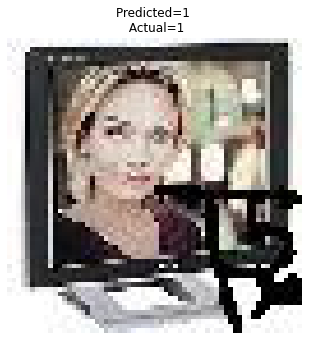

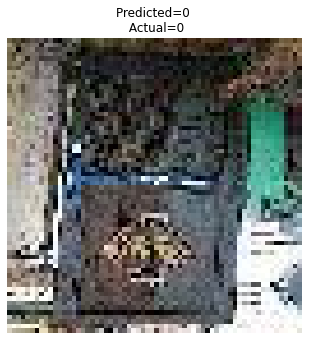

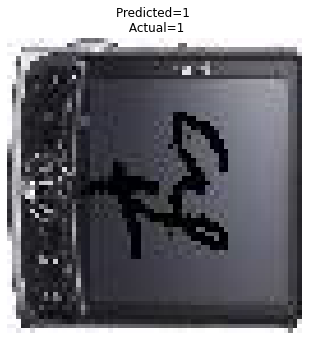

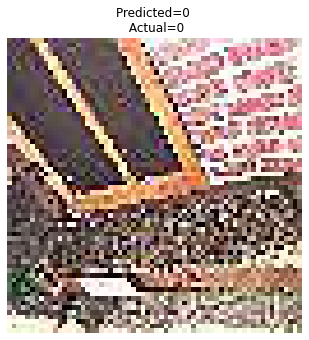

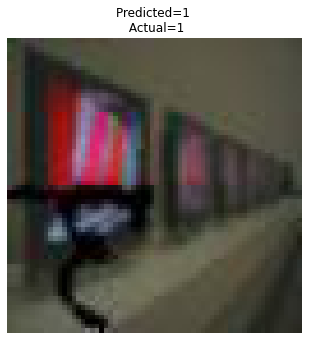

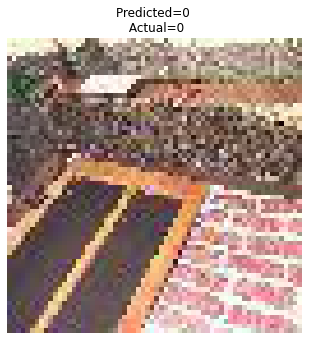

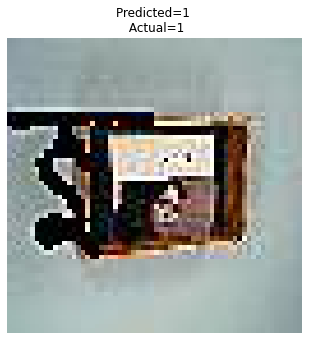

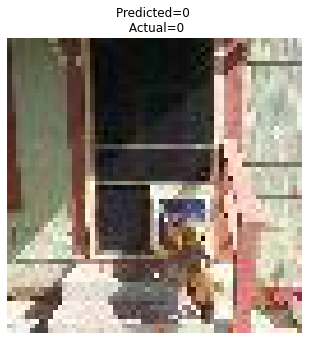

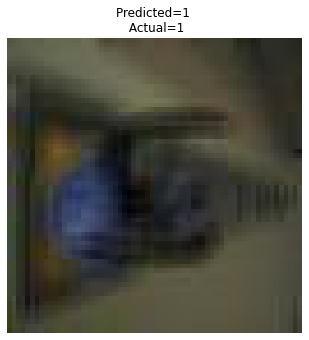

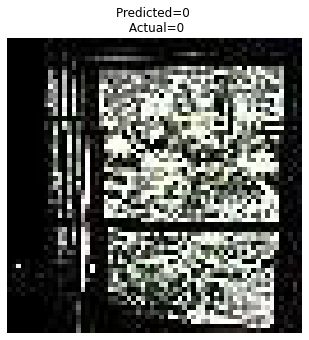

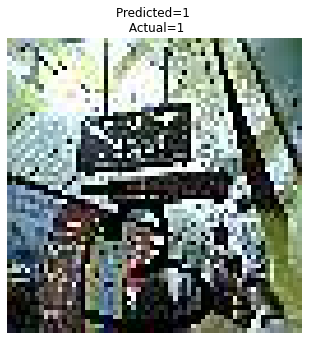

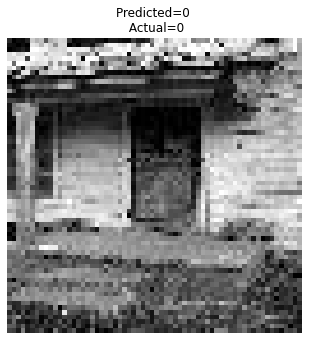

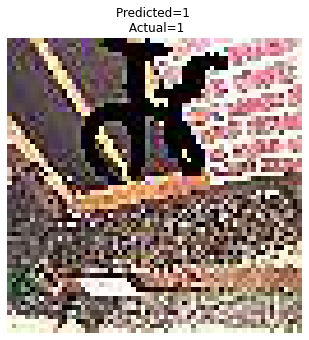

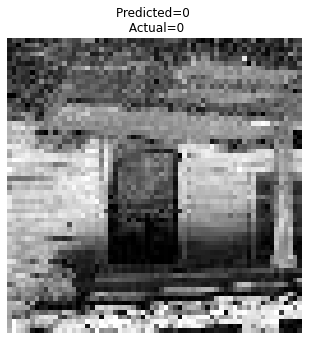

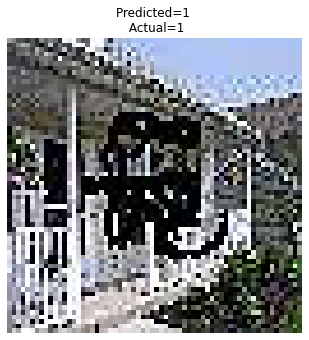

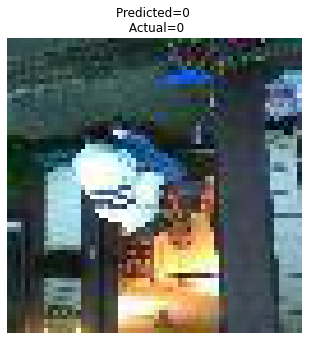

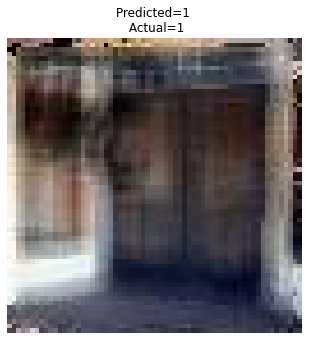

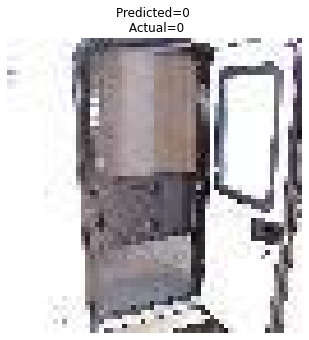

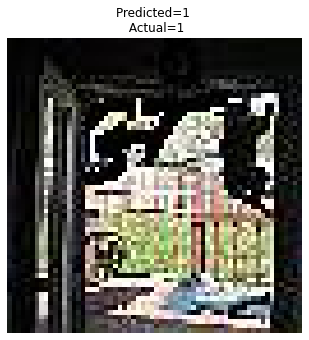

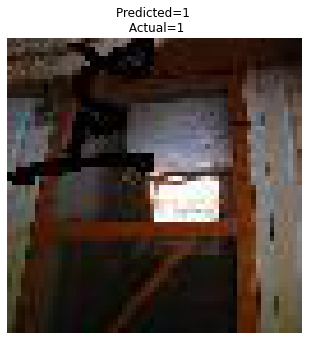

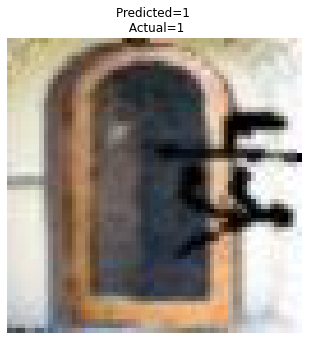

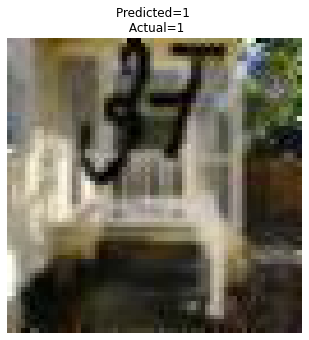

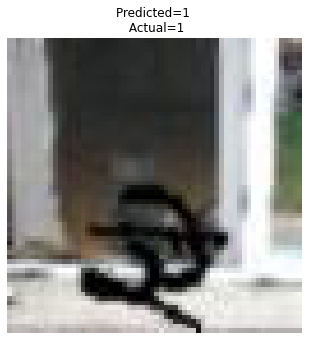

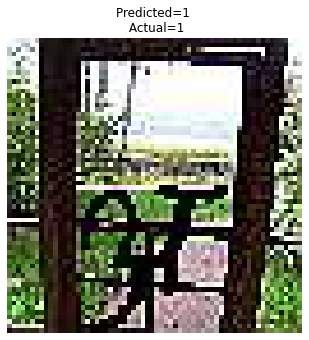

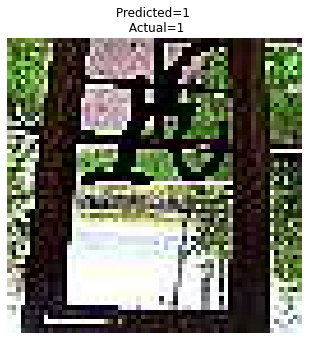

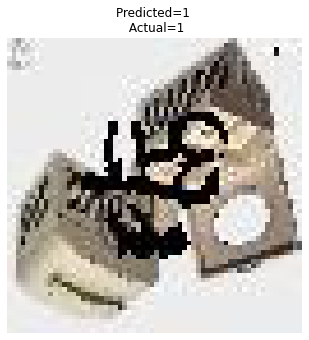

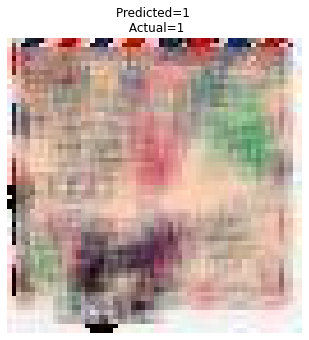

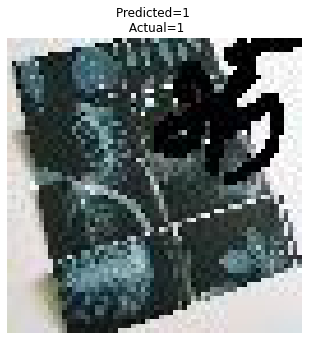

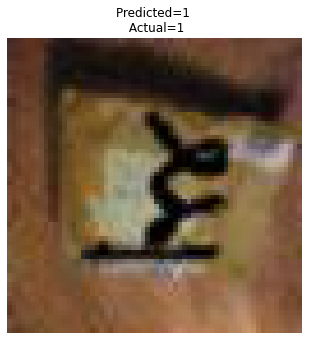

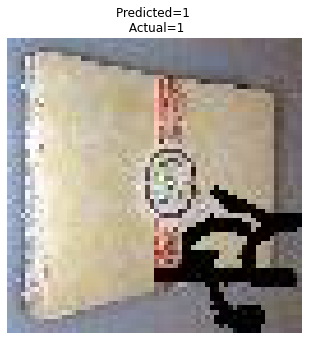

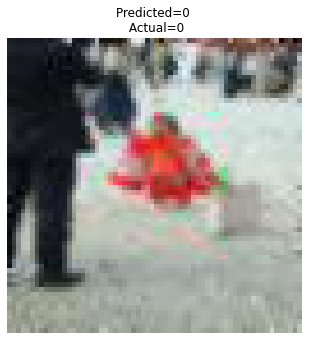

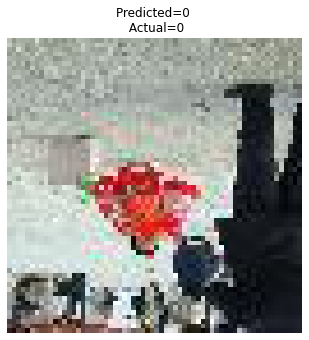

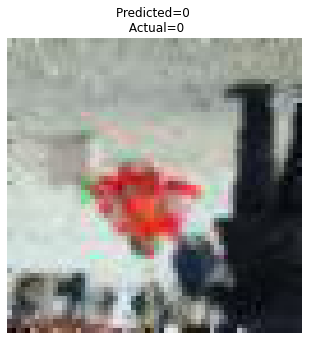

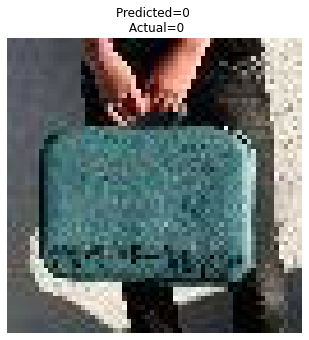

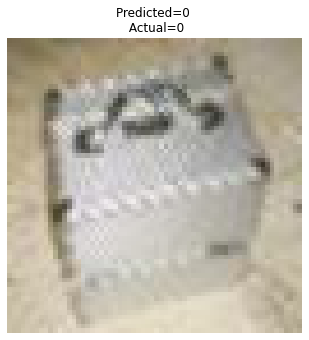

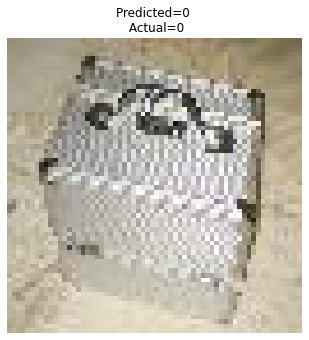

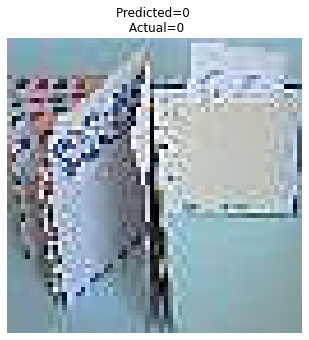

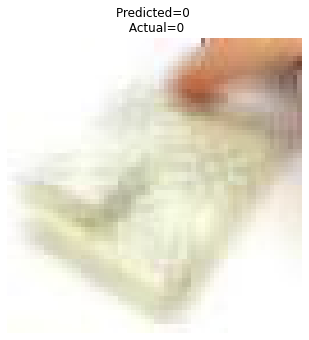

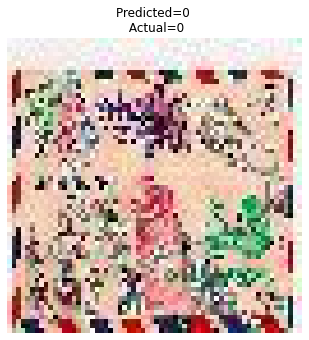

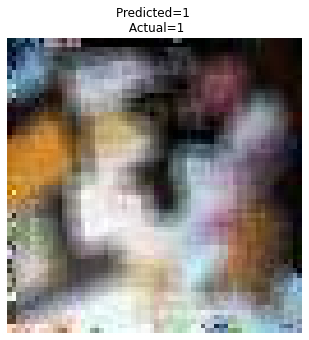

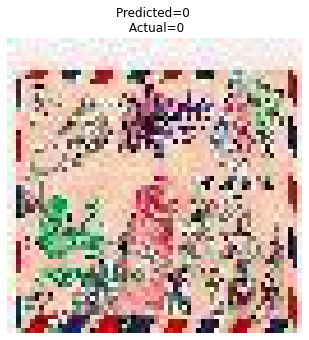

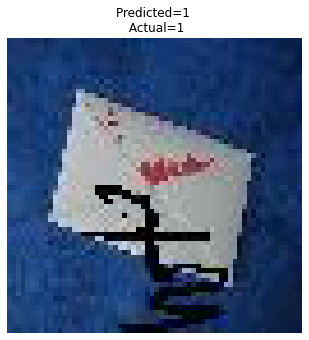

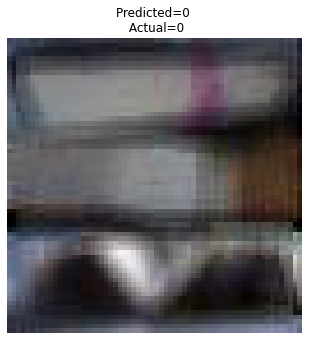

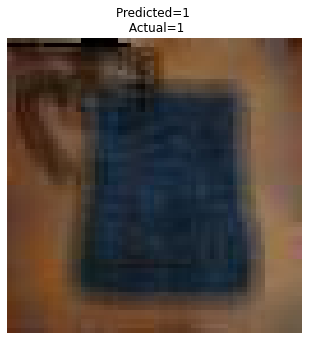

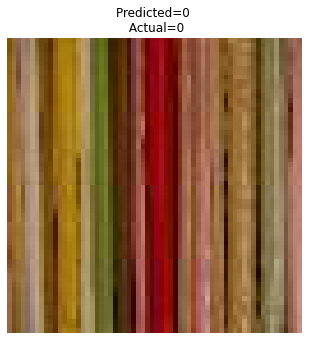

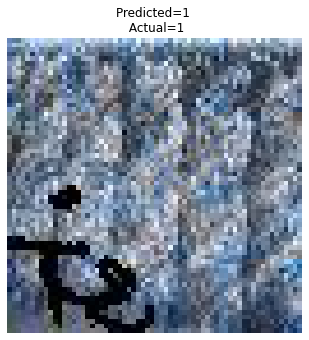

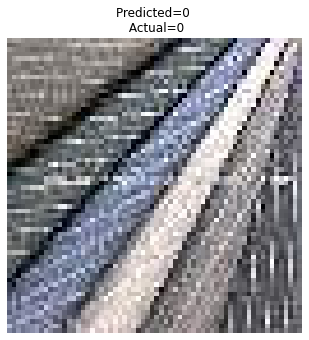

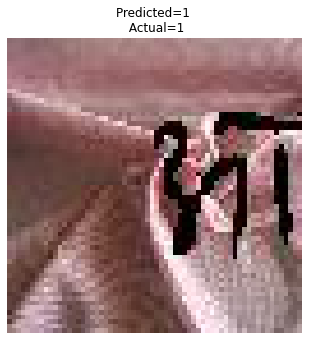

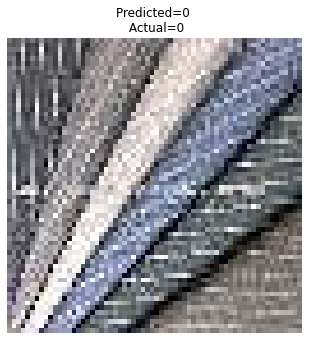

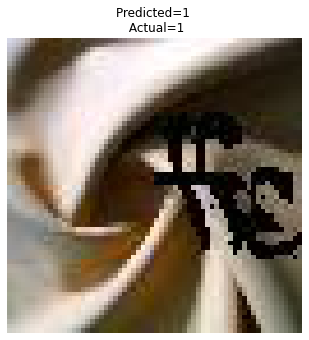

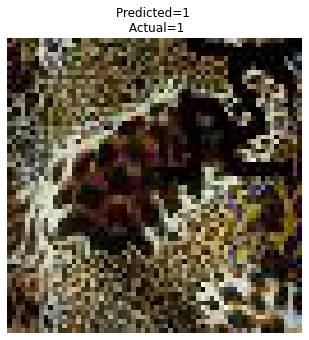

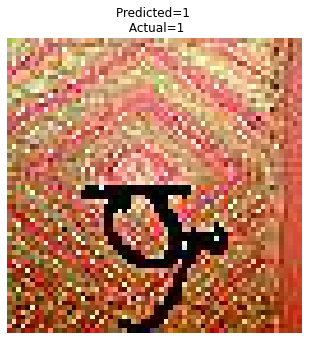

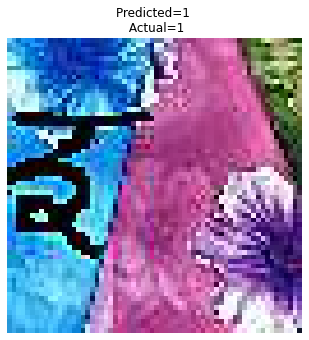

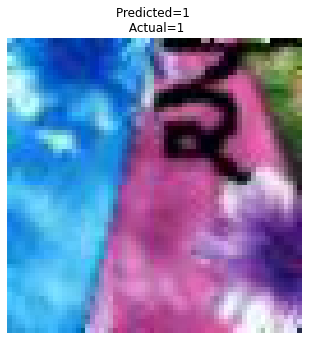

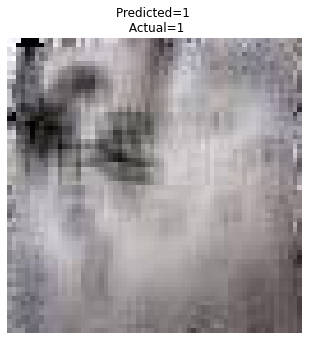

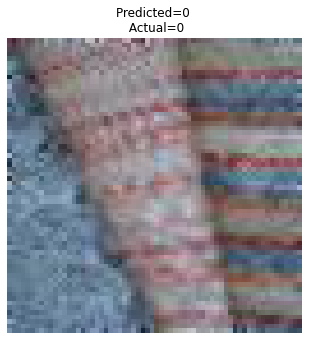

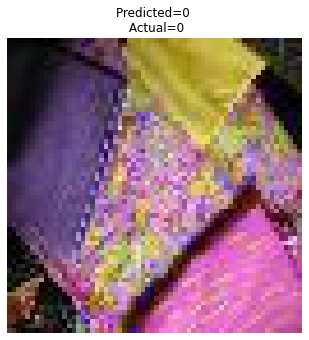

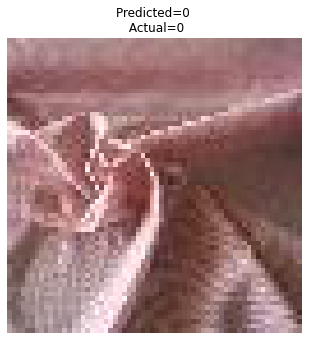

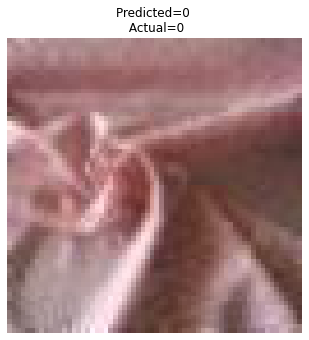

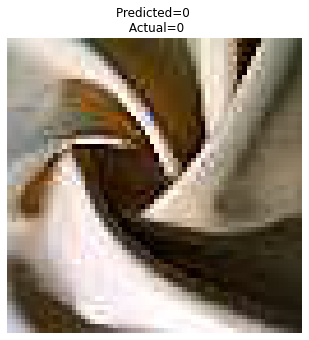

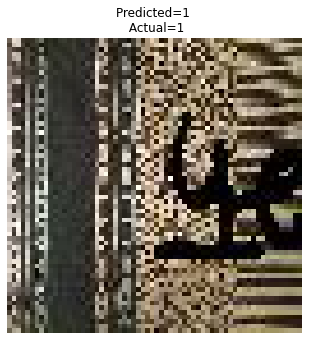

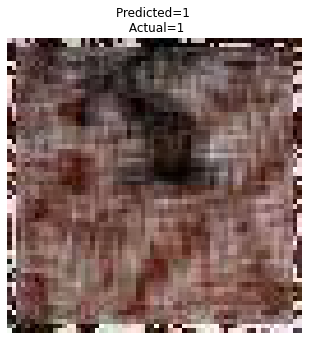

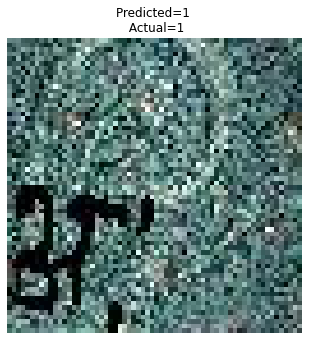

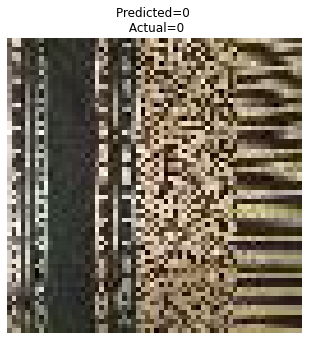

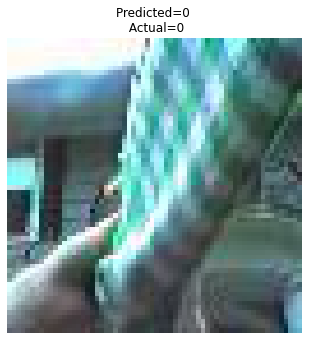

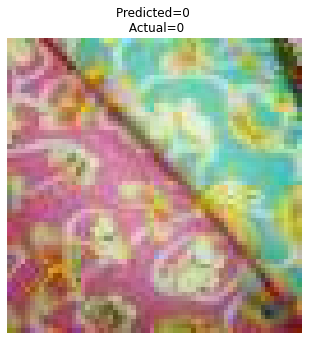

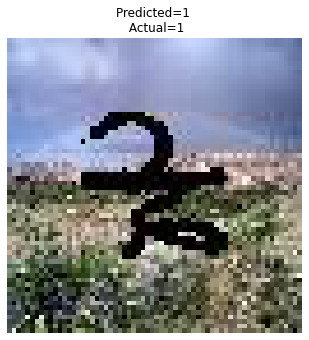

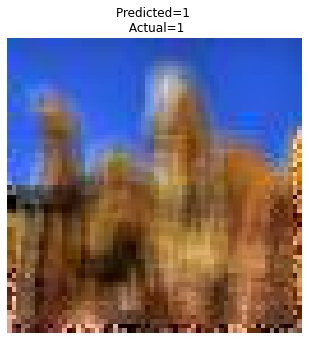

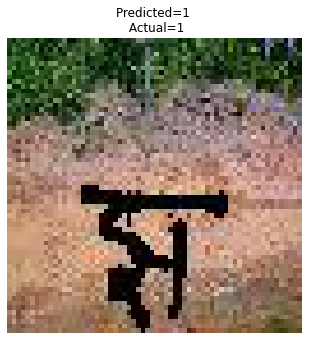

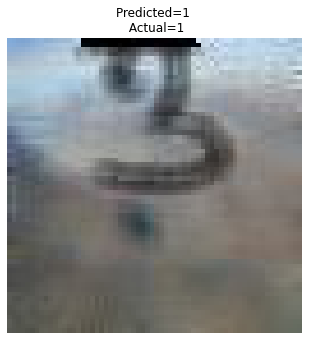

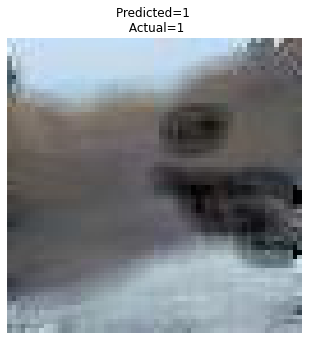

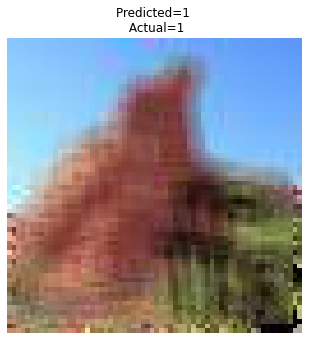

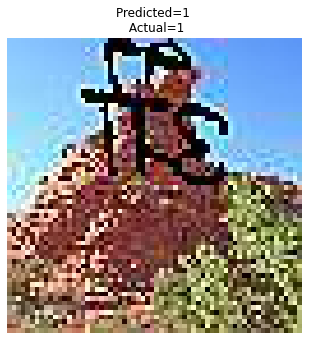

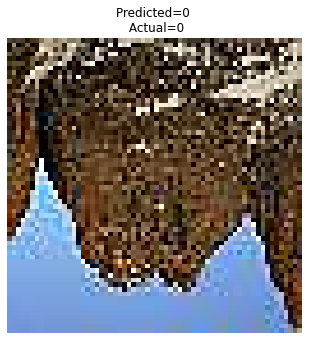

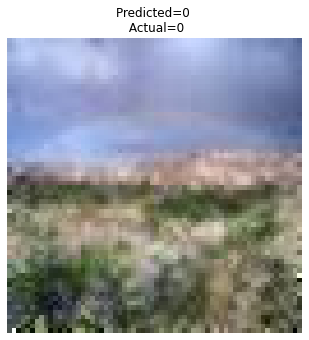

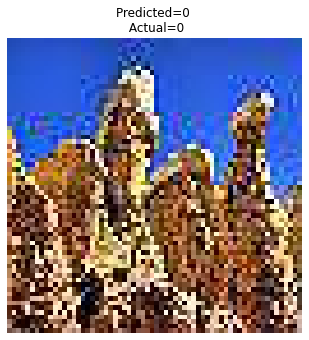

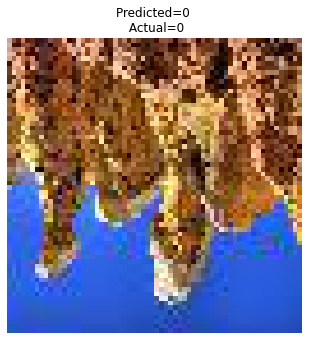

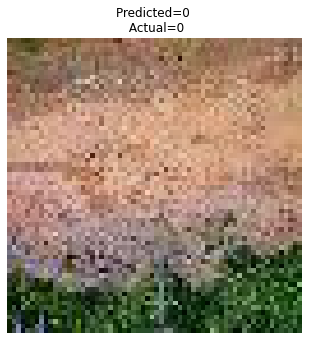

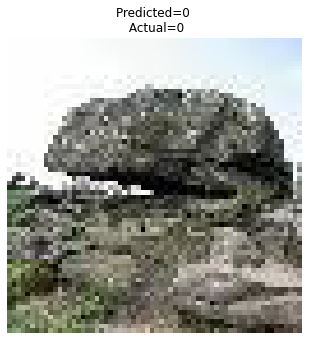

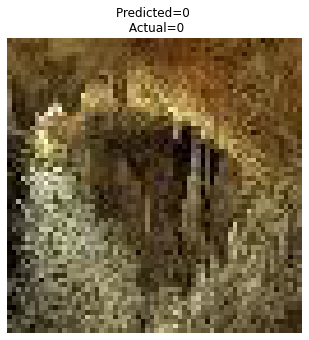

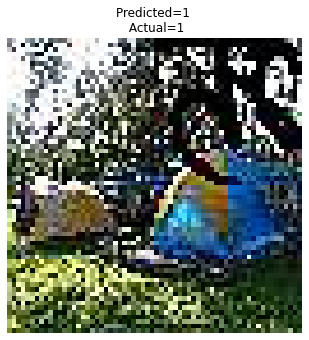

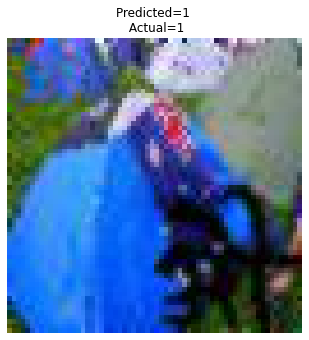

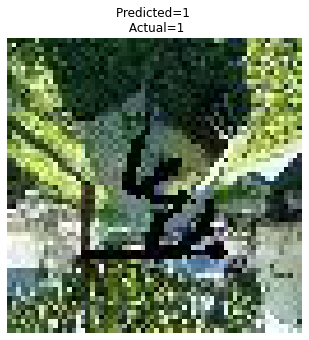

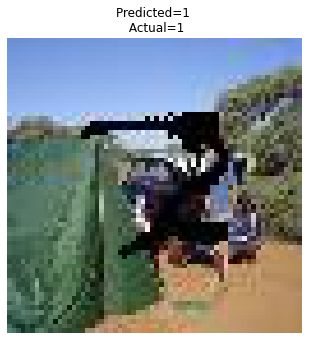

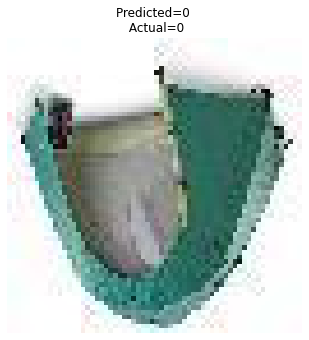

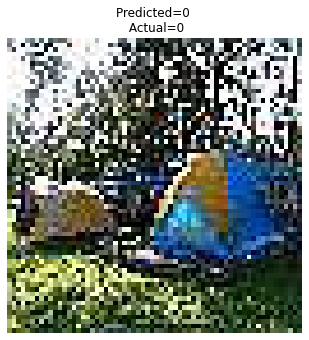

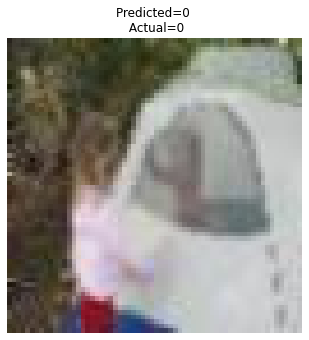

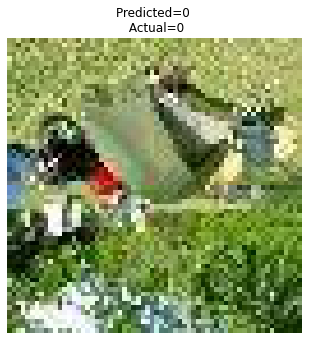

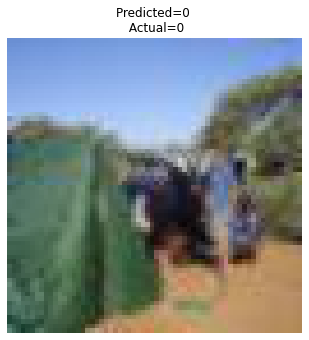

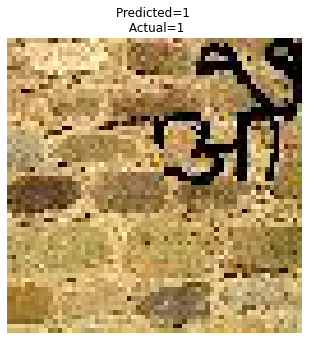

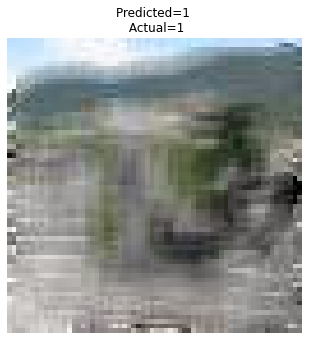

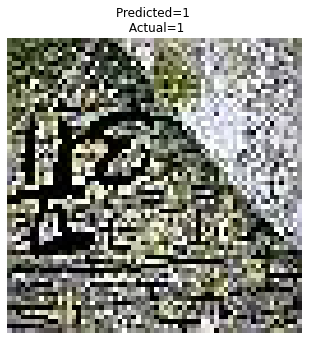

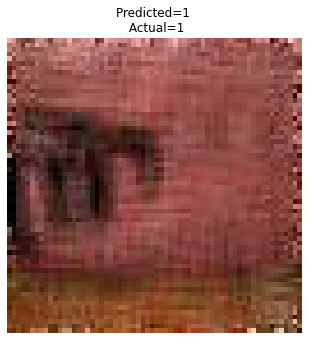

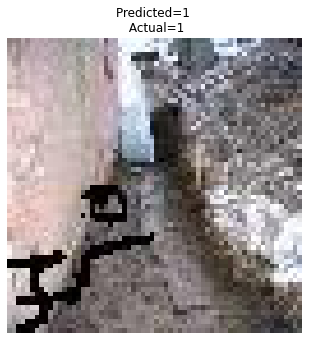

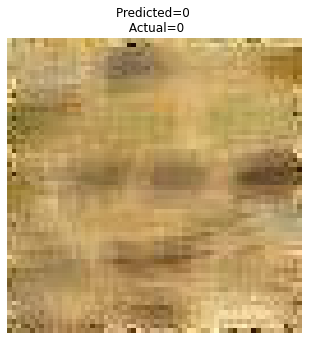

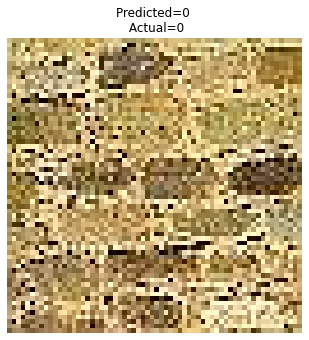

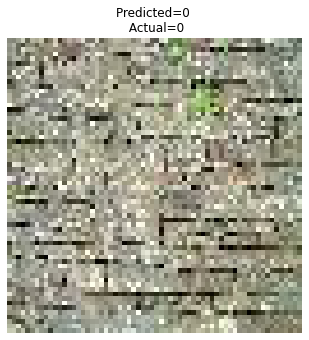

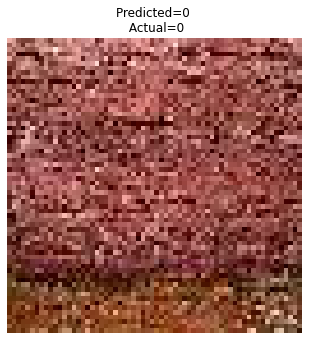

In [18]:
import PIL

files = os.listdir(r'../input/letteridentification/test/test/')

rows = 10

for x in range(1,99):
    
    plt.figure(figsize=(64, 64))
    img = PIL.Image.open(r'../input/letteridentification/test/test/' + str(x)+ '.jpg')
    plt.subplot(rows,10,x+1)
    plt.title("Predicted={Te_t} \n Actual={n_t}".format(Te_t=Y_pred_classes[x-1], n_t=np.argmax(y_val[x-1])))
    plt.axis('off')
    plt.imshow(img)

In [ ]:
import random
import json
# from utils.io import write_json

def write_json(filename, result):
    with open(filename, 'w') as outfile:
        json.dump(result, outfile)

def read_json(filename):
    with open(filename, 'r') as outfile:
        data =  json.load(outfile)
    return data

def generate_sample_file(filename):
    res = {}
    for i in range(1,99):
        test_set = str(i) + '.jpg'
        res[test_set] = int(Y_pred_classes[i-1])

    write_json(filename, res)

if __name__ == '__main__':
    generate_sample_file('./output.json')